In [81]:
import numpy as np
import pandas as pd

from gensim.models.fasttext import FastText
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Concatenate, Reshape, LSTM

import matplotlib.pyplot as plt

%matplotlib inline

# load data

In [128]:
df_chats = pd.read_csv('../data/train/chats_train.csv')
df_prices = pd.read_csv('../data/train/tickers_train.csv', index_col=0)

## prepare price data

In [129]:
TICKER = 'ETH'
df_prices = df_prices[df_prices['ticker'] == TICKER].copy()

In [130]:
df_prices.head(2)

,datetime,name,priceBtc,priceUsd,ticker,volume
0,2018-03-01T00:00:00Z,Ethereum,0.082836,856.952292,ETH,1.979010e+09
1,2018-03-01T02:00:00Z,Ethereum,0.082887,858.979167,ETH,1.931840e+09


In [131]:
df_prices['delta_price_usd'] = (df_prices['priceUsd'] - df_prices['priceUsd'].shift(1)) / df_prices['priceUsd'].shift(1)

In [132]:
df_prices['delta_price_usd'].fillna(0, inplace=True)

In [133]:
quantile1 = df_prices['delta_price_usd'].quantile(q=0.33)
quantile2 = df_prices['delta_price_usd'].quantile(q=0.66)

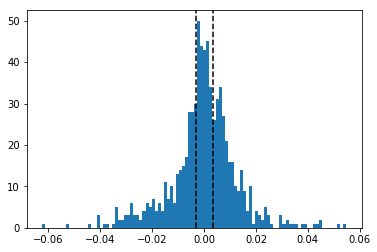

In [134]:
plt.hist(df_prices['delta_price_usd'], bins=100)
plt.axvline(quantile1, color='k', linestyle='dashed')
plt.axvline(quantile2, color='k', linestyle='dashed')
plt.show()

In [135]:
print(
    df_prices[df_prices['delta_price_usd'] < quantile1].shape,
    df_prices[df_prices['delta_price_usd'] > quantile2].shape,
    df_prices[(df_prices['delta_price_usd'] > quantile1) & (df_prices['delta_price_usd'] < quantile2)].shape,
)

(242, 7) (249, 7) (241, 7)


In [136]:
df_prices['timestamp'] = pd.to_datetime(df_prices['datetime']).apply(lambda x: x.timestamp())

In [137]:
df_prices.head()

,datetime,name,priceBtc,priceUsd,ticker,volume,delta_price_usd,timestamp
0,2018-03-01T00:00:00Z,Ethereum,0.082836,856.952292,ETH,1.979010e+09,0.000000,1.519862e+09
1,2018-03-01T02:00:00Z,Ethereum,0.082887,858.979167,ETH,1.931840e+09,0.002365,1.519870e+09
2,2018-03-01T04:00:00Z,Ethereum,0.082744,861.494542,ETH,1.908910e+09,0.002928,1.519877e+09
3,2018-03-01T06:00:00Z,Ethereum,0.082734,862.998542,ETH,1.866320e+09,0.001746,1.519884e+09
4,2018-03-01T08:00:00Z,Ethereum,0.081945,869.481042,ETH,1.834750e+09,0.007512,1.519891e+09


## prepare chat data

In [138]:
df_chats.head()

,chat_id,chat_title,emoji_list,sender_first_name,sender_id,sender_is_bot,sender_last_name,sender_username,text,timestamp
0,1129149026,Pareto Network - Discussion,[],Bezant,526106862,False,None,None,Admin disputes in private thank you.,1524284160
1,1129149026,Pareto Network - Discussion,[],Sheriff,538526216,False,None,None,I see Binance add coins all the time on the Cr...,1524284160
2,1146170349,Binance English,[],DaySandBox,400753764,True,None,daysandbox_bot,Removed msg from __Megzon Kadrija__. Reason: n...,1524285614
3,1146170349,Binance English,[],Kamalendu,435609627,False,Pal,None,Bc xvg dead,1524285372
4,1146170349,Binance English,[':thumbsup:'],Abdelbari,154857846,False,K,None,"Yes, youre right 👍",1524286342


In [139]:
df_chats['ind'] = list(range(df_chats.shape[0]))

In [140]:
PERIOD = 8*3600

news_counts = []
for i, row in df_prices.iterrows():
    ts = row['timestamp']
    c = df_chats[(df_chats['timestamp'] < ts) & (df_chats['timestamp'] > ts - PERIOD)].shape[0]
    news_counts.append(c)

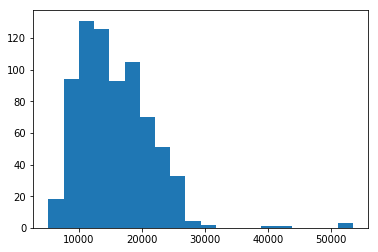

In [141]:
plt.hist(news_counts, bins=20)
plt.show()

In [142]:
chat_ids = list(df_chats['chat_id'].unique())
chat_ids.sort()
chat2ind = {chat_id: i for i, chat_id in enumerate(chat_ids)}

sender_ids = list(df_chats['sender_id'].unique())
sender_ids.sort()
sender2ind = {sender_id: i for i, sender_id in enumerate(sender_ids)}

In [143]:
df_chats['chat_ind'] = df_chats['chat_id'].apply(lambda x: chat2ind[x])
df_chats['sender_ind'] = df_chats['sender_id'].apply(lambda x: sender2ind[x])

### load fasttext vectors

In [144]:
vectors = np.load('../data/chat_vectors_100.npy')

### prepare data for buy model

In [145]:
df_chats['sender_is_bot'] = df_chats['sender_is_bot'].apply(lambda x: int(x))

In [156]:
inp_fasttext = []
inp_sender_bot = []
inp_chat_ind = []
inp_sender_ind = []
inp_timedelta_log = []
out_target = [] # grow more than 0.66 quantile, not drawdown less 0.33 quantile in period 48 hours

In [157]:
TARGET_MIN_UP = 1.1
TARGET_MAX_DOWN = 0.95
SAMPLES = 10
STEPS = 256

for i, row in df_prices.iterrows():
    for sample in range(SAMPLES):
        ts = row['timestamp']

        df_chats_sample = df_chats[(df_chats['timestamp'] > ts - 48 * 3600) & (df_chats['timestamp'] < ts)].sample(STEPS)
        df_chats_sample['timedelta'] = np.log(-(df_chats_sample['timestamp'] - ts))

        chat_indexes = df_chats_sample['ind'].values

        batch_fasttext = vectors[chat_indexes]
        batch_sender_bot = df_chats.iloc[chat_indexes]['sender_is_bot'].values
        batch_chat_ind = df_chats.iloc[chat_indexes]['chat_ind'].values
        batch_sender_ind = df_chats.iloc[chat_indexes]['sender_ind'].values
        batch_timedelta = df_chats_sample['timedelta'].values

        df_prices_forward = df_prices[(df_prices['timestamp'] > ts) & (df_prices['timestamp'] + 48 * 3600)].copy()
        if df_prices_forward.shape[0] < 24:
            continue
        df_prices_forward['priceUsd'] /= df_prices_forward['priceUsd'].values[0]

        target = False
        for price_relative in df_prices_forward['priceUsd'].values:
            if price_relative < TARGET_MAX_DOWN:
                target = False
                break
            if price_relative > TARGET_MIN_UP:
                target = True
                break

        inp_fasttext.append(batch_fasttext)
        inp_sender_bot.append(batch_sender_bot)
        inp_chat_ind.append(batch_chat_ind)
        inp_sender_ind.append(batch_sender_ind)
        inp_timedelta_log.append(batch_timedelta)
        out_target.append(target)

In [158]:
inp_fasttext = np.array(inp_fasttext)
inp_sender_bot = np.array(inp_sender_bot)
inp_chat_ind = np.array(inp_chat_ind)
inp_sender_ind = np.array(inp_sender_ind)
inp_timedelta_log = np.array(inp_timedelta_log)

out_target = np.array(out_target)

In [159]:
inp_sender_bot = np.expand_dims(inp_sender_bot, 2)

In [160]:
inp_chat_ind = np.expand_dims(inp_chat_ind, 2)

In [161]:
inp_sender_ind = np.expand_dims(inp_sender_ind, 2)

In [162]:
inp_timedelta_log = np.expand_dims(inp_timedelta_log, 2)

In [163]:
inp_layer_fasttext = Input(shape=(STEPS, 100, ), name='inp_layer_fasttext')
inp_layer_sender_bot = Input(shape=(STEPS, 1, ), name='inp_layer_sender_bot')
inp_layer_chat = Input(shape=(STEPS, 1, ), name='inp_layer_chat')
inp_layer_sender = Input(shape=(STEPS, 1, ), name='inp_layer_sender')
inp_layer_timedelta = Input(shape=(STEPS, 1, ), name='inp_layer_timedelta')

sender_embedding = Embedding(len(sender2ind), 128)(inp_layer_sender)
chat_embedding = Embedding(len(chat2ind), 8)(inp_layer_chat)

sender_embedding = Reshape((STEPS, 128))(sender_embedding)
chat_embedding = Reshape((STEPS, 8))(chat_embedding)

common_layer = Concatenate(axis=-1)([
    inp_layer_fasttext, inp_layer_sender_bot, chat_embedding, sender_embedding, inp_layer_timedelta])

lstm = LSTM(128)(common_layer)

dense = Dense(1, activation='sigmoid')(lstm)

model = Model(
    inputs=[inp_layer_fasttext, inp_layer_sender_bot, inp_layer_chat, inp_layer_sender, inp_layer_timedelta],
    outputs=dense
)

model.compile(optimizer='adam', loss='binary_crossentropy')

In [164]:
test_size = int(inp_fasttext.shape[0] * 0.1)

In [165]:
model.fit(
    [inp_fasttext[:-test_size], inp_sender_bot[:-test_size], inp_chat_ind[:-test_size], inp_sender_ind[:-test_size], inp_timedelta_log[:-test_size]],
    out_target[:-test_size],
    validation_data=[
        [inp_fasttext[-test_size:], inp_sender_bot[-test_size:], inp_chat_ind[-test_size:], inp_sender_ind[-test_size:], inp_timedelta_log[-test_size:]],
        out_target[-test_size:]
    ],
    epochs=10
)

Train on 6372 samples, validate on 708 samples
Epoch 1/10
6372/6372 [==============================] - 59s 9ms/step - loss: 0.3956 - val_loss: 1.7974
Epoch 2/10
6372/6372 [==============================] - 59s 9ms/step - loss: 0.1409 - val_loss: 2.4783
Epoch 3/10
6372/6372 [==============================] - 59s 9ms/step - loss: 0.0385 - val_loss: 2.7842
Epoch 4/10
6372/6372 [==============================] - 59s 9ms/step - loss: 0.0038 - val_loss: 3.8096
Epoch 5/10
6372/6372 [==============================] - 59s 9ms/step - loss: 4.4915e-04 - val_loss: 5.3348
Epoch 6/10
6372/6372 [==============================] - 59s 9ms/step - loss: 1.8141e-04 - val_loss: 5.9734
Epoch 7/10
6372/6372 [==============================] - 59s 9ms/step - loss: 1.0997e-04 - val_loss: 6.3487
Epoch 8/10
6372/6372 [==============================] - 58s 9ms/step - loss: 7.7604e-05 - val_loss: 6.6453
Epoch 9/10
6372/6372 [==============================] - 58s 9ms/step - loss: 5.9407e-05 - val_loss: 6.8534
Epoch 